In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit,prange
import time
from matplotlib.cm import ScalarMappable
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
import math
from IPython.display import HTML  



import warnings as kxe_kxe
kxe_kxe.filterwarnings('ignore')

In [ ]:
@njit(nopython=True, parallel=True) # 4:49 min
def compute_integ(x, y, V, D_x1, D_y1, I_u, x_ku, y_ku, sigma_U_x, sigma_U_y):
    N, M = V.shape
    out = 0.0

    i_min = max(0, x - D_x1)
    i_max = min(M - 1, x + D_x1)
    j_min = max(0, y - D_y1)
    j_max = min(N - 1, y + D_y1)

    denom_x = 2.0 * sigma_U_x**2
    denom_y = 2.0 * sigma_U_y**2

    coeff_x = -1.0 / denom_x
    coeff_y = -1.0 / denom_y

    # Предвычисление экспонент для x
    exp_x = [0.0] * (i_max - i_min + 1)
    for idx_i, i in enumerate(range(i_min, i_max + 1)):
        di = i - x_ku
        exp_x[idx_i] = math.exp(di * di * coeff_x)

    # Предвычисление экспонент для y
    exp_y = [0.0] * (j_max - j_min + 1)
    for idx_j, j in enumerate(range(j_min, j_max + 1)):
        dj = j - y_ku
        exp_y[idx_j] = math.exp(dj * dj * coeff_y)

    # Параллельный цикл по j
    total = 0.0
    for idx_j in prange(len(exp_y)):
        j_val = j_min + idx_j
        ey = exp_y[idx_j]
        local_sum = 0.0
        for idx_i in range(len(exp_x)):
            i_val = i_min + idx_i
            ex = exp_x[idx_i]
            local_sum += I_u * ex * ey * V[j_val, i_val]
        total += local_sum

    return total

In [ ]:
@njit
def T(x,y,V,U,b_v,d_v,c_u,integ):
  return b_v * V[y,x] - d_v * V[y,x]**2 - c_u * U[y,x] * V[y,x] + integ

@njit(nopython=True, fastmath=True, parallel=True)
def plots_opt(h, U, V,
                 c_u, b_u, d_u, I_u, x_ku, y_ku, sigma_U_x, sigma_U_y,
                 c_v, b_v, d_v, I_v, x_kv, y_kv, sigma_V_x, sigma_V_y,
                 D_x1, D_y1,
                 D_x2, D_y2):
    y_lim, x_lim = V.shape
    U_new = np.zeros(U.shape)
    V_new = np.zeros(V.shape)
    
    k0 = np.zeros(V.shape)
    k1 = np.zeros(V.shape)
    k2 = np.zeros(V.shape)
    k3 = np.zeros(V.shape)
    
    l0 = np.zeros(U.shape)
    l1 = np.zeros(U.shape)
    l2 = np.zeros(U.shape)
    l3 = np.zeros(U.shape)

    h_over_2 = h / 2
    h_over_6 = h / 6

    # k0, l0
    for x in prange(x_lim):
        for y in range(y_lim):
            integ = compute_integ(x, y, V, D_x1, D_y1, I_u, x_ku, y_ku, sigma_U_x, sigma_U_y)
            k0[y, x] = T(x, y, V, U, b_v, d_v, c_u, integ)

            integ = compute_integ(x, y, U, D_x2, D_y2, I_v, x_kv, y_kv, sigma_V_x, sigma_V_y)
            l0[y, x] = T(x, y, U, V, b_u, d_u, c_v, integ)

    # k1, l1
    V1 = V + h_over_2 * k0
    U1 = U + h_over_2 * l0

    for x in prange(x_lim):
        for y in range(y_lim):
            integ = compute_integ(x, y, V1, D_x1, D_y1, I_u, x_ku, y_ku, sigma_U_x, sigma_U_y)
            k1[y, x] = T(x, y, V1, U1, b_v, d_v, c_u, integ)

            integ = compute_integ(x, y, U1, D_x2, D_y2, I_v, x_kv, y_kv, sigma_V_x, sigma_V_y)
            l1[y, x] = T(x, y, U1, V1, b_u, d_u, c_v, integ)

    # k2, l2
    V2 = V + h_over_2 * k1
    U2 = U + h_over_2 * l1

    for x in prange(x_lim):
        for y in range(y_lim):
            integ_v = compute_integ(x, y, V2, D_x1, D_y1, I_u, x_ku, y_ku, sigma_U_x, sigma_U_y)
            k2[y, x] = T(x, y, V2, U2, b_v, d_v, c_u, integ_v)

            integ_u = compute_integ(x, y, U2, D_x2, D_y2, I_v, x_kv, y_kv, sigma_V_x, sigma_V_y)
            l2[y, x] = T(x, y, U2, V2, b_u, d_u, c_v, integ_u)

    # k3, l3
    V3 = V + h * k2
    U3 = U + h * l2

    for x in prange(x_lim):
        for y in range(y_lim):
            integ_v = compute_integ(x, y, V3, D_x1, D_y1, I_u, x_ku, y_ku, sigma_U_x, sigma_U_y)
            k3[y, x] = T(x, y, V3, U3, b_v, d_v, c_u, integ_v)

            integ_u = compute_integ(x, y, U3, D_x2, D_y2, I_v, x_kv, y_kv, sigma_V_x, sigma_V_y)
            l3[y, x] = T(x, y, U3, V3, b_u, d_u, c_v, integ_u)

    # Финальное обновление
    V_new[:] = V + h_over_6 * (k0 + 2*k1 + 2*k2 + k3)
    U_new[:] = U + h_over_6 * (l0 + 2*l1 + 2*l2 + l3)

    return U_new, V_new

Для примера пары конкурирующих популяций можно рассмотреть **сардину-иваси** (*Sardinops sagax*) и **японского анчоуса** (*Engraulis japonicus*), которые конкурируют за общий ресурс — планктон. При высокой численности сардин-иваси снижается популяция японского анчоуса из-за ограниченного доступа к пищевым ресурсам. 

### Обоснование:
1. **Межвидовая конкуренция**: Оба вида питаются планктоном, что делает их прямыми конкурентами за пищевой ресурс.
2. **Эксплуатационная конкуренция**: Сардины-иваси эффективнее потребляют планктон, что приводит к снижению его доступности для анчоусов .
3. **Влияние на численность**: При увеличении численности сардин-иваси наблюдается уменьшение численности японского анчоуса, что подтверждает негативное влияние одной популяции на другую.

Этот пример иллюстрирует типичную **косвенную конкуренцию** (эксплуатационную), когда организмы конкурируют за общий ресурс, не взаимодействуя напрямую

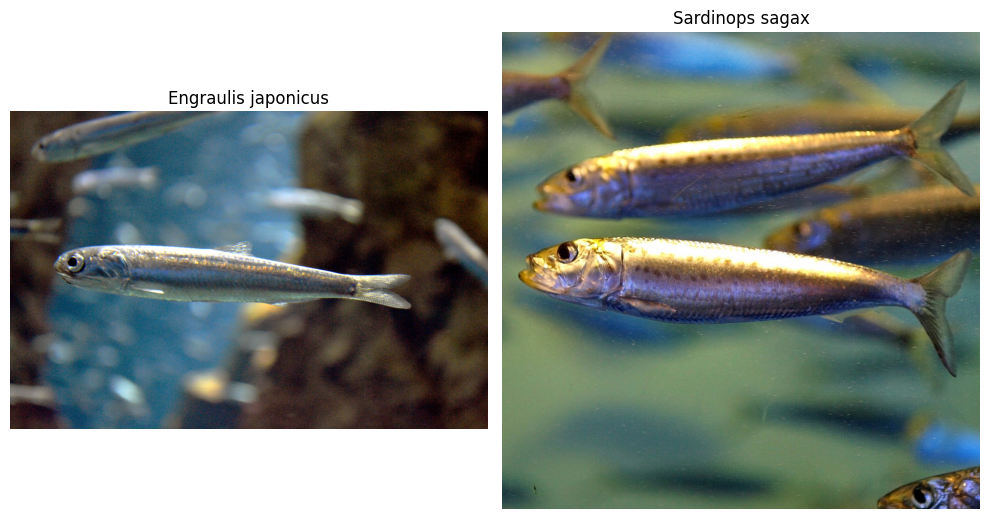

In [5]:
from PIL import Image
img1 = Image.open("data\Sardinops_melanostictus.jpg")
img_array1 = np.array(img1, dtype=float) / 255.0

img2 = Image.open("data\Engraulis_japonicus_01.jpg")
img_array2 = np.array(img2, dtype=float) / 255.0

fig, axes = plt.subplots(1, 2, figsize=(10, 10))


axes[0].imshow(img_array2)
axes[0].axis('off')
axes[0].set_title('Engraulis japonicus')

axes[1].imshow(img_array1)
axes[1].axis('off')
axes[1].set_title('Sardinops sagax')


plt.tight_layout()
plt.show()

In [ ]:
def make_gif(h,
             c_u, b_u, d_u, I_u, sigma_U_x, sigma_U_y,
             c_v, b_v, d_v, I_v, sigma_V_x, sigma_V_y,
             D_x1, D_y1,
             D_x2, D_y2,
             num_frames=100, fps=10, filename='population_dynamics.html', label1='Популяция_1', label2='Популяция_2', gridsize=100):
    

    start_time = time.time()
    
    x_ku = y_ku = 0.8*gridsize
    x_kv = y_kv = 0.2*gridsize
    
    
    U0 = np.zeros((gridsize, gridsize))
    V0 = np.zeros((gridsize, gridsize))
    
    # Начальные популяции в углах
    U0[ gridsize*1//8: gridsize*3//8,  gridsize*1//8: gridsize*3//8] = 1.0  # Левый верхний угол
    V0[-gridsize*3//8:-gridsize*1//8, -gridsize*3//8:-gridsize*1//8] = 1.0  # Правый нижний угол
    

    
    U = U0.copy()
    V = V0.copy()

    # Фиксированные цветовые карты
    colors_v = [(0,0,0,0), (1,1,1,0.3), (1,0,0,1)]  # Градиент от белого до красного
    colors_u = [(0,0,0,0), (1,1,1,0.3), (0,0,1,1)]  # Градиент от белого до синего
    cmap_v = LinearSegmentedColormap.from_list(label1, colors_v)
    cmap_u = LinearSegmentedColormap.from_list(label2, colors_u)

    # Фиксированные пределы нормализации (если известны)
    vmax_v = max(1e-3, np.max(V0))  
    vmax_u = max(1e-3, np.max(U0))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title("Динамика конкурирующих популяций")
    ax.set_xticks([])
    ax.set_yticks([])

    img_v = ax.imshow(V0, cmap=cmap_v, vmin=0, vmax=vmax_v, alpha=0.7, interpolation='bilinear')
    img_u = ax.imshow(U0, cmap=cmap_u, vmin=0, vmax=vmax_u, alpha=0.7, interpolation='bilinear')

    cbar_v = fig.colorbar(ScalarMappable(cmap=cmap_v), ax=ax, label=label1)
    cbar_u = fig.colorbar(ScalarMappable(cmap=cmap_u), ax=ax, label=label2)

    def update(frame):
        nonlocal U, V
        U, V = plots_opt(h, U, V,
                            c_u, b_u, d_u, I_u, x_ku, y_ku, sigma_U_x, sigma_U_y,
                            c_v, b_v, d_v, I_v, x_kv, y_kv, sigma_V_x, sigma_V_y,
                            D_x1, D_y1,
                            D_x2, D_y2)

        U[U < 0] = 0
        V[V < 0] = 0

        img_v.set_array(V)
        img_u.set_array(U)
        ax.set_title(f"Шаг {frame}, t={frame*h:.2f}")
        print(f"Шаг {frame}, t={frame*h:.2f}")
        return img_v, img_u

    ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=1000//fps, blit=True)
    #ani.save(filename, writer='pillow', fps=fps, dpi=100)
    htmlka = ani.to_jshtml(fps)
    with open(filename,'w') as f:
        f.write(htmlka)
    plt.close()
    print(f"Анимация сохранена как {filename}")
    
    print(f'На выполнение понадобилось {(time.time() - start_time):.4f} секунд')
    
    return htmlka, ani

htmlka, ani = make_gif(h=0.05,
        c_u=0.35, b_u=0.7, d_u=0.15, I_u=0.003, sigma_U_x=20, sigma_U_y=20,
        c_v=0.4, b_v=0.8, d_v=0.1, I_v=0.003, sigma_V_x=20, sigma_V_y=20,
        D_x1=190, D_y1=190,
        D_x2=180, D_y2=180,
        num_frames=10, fps=10, filename='populations.html',gridsize=802, label1='Engraulis japonicus',label2='Sardinops sagax')

Шаг 0, t=0.00
Шаг 0, t=0.00
Шаг 0, t=0.00
Шаг 0, t=0.00
Шаг 1, t=0.05
Шаг 2, t=0.10
Шаг 3, t=0.15
Шаг 4, t=0.20
Шаг 5, t=0.25
Шаг 6, t=0.30
Шаг 7, t=0.35
Шаг 8, t=0.40
Шаг 9, t=0.45
Анимация сохранена как populations.html
На выполнение понадобилось 1656.1148 секунд


In [11]:
HTML(htmlka)